In [1]:
import chess
import chess.engine
import random
import numpy


# this function will create our x (board)
def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board


# this function will create our f(x) (score)
def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci('newStockfish/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2') as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

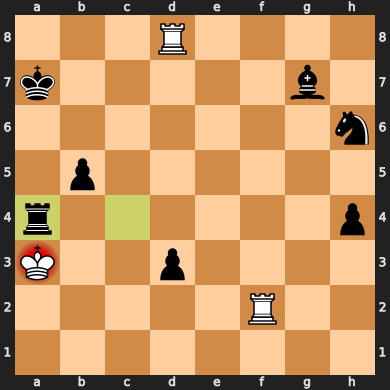

In [5]:
board = random_board()
board

In [6]:
print(stockfish(board, 10))

-341


The Idea is that the Deep Learning Network will predict this score based on the positions of the pieces on the board.

# Creating the dataset

Now we need to convert the board representation to something meaningful.
A 3d matrix of sizes **8 x 8 x 14** where 8x8 repersents the board and the 14 represents the 7 different pieces 

In [7]:
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}


# example: h3 -> 17
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]


def split_dims(board):
  # this is the 3d matrix
  board3d = numpy.zeros((14, 8, 8), dtype=numpy.int8)

  # here we add the pieces's view on the matrix
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # add attacks and valid moves too
  # so the network knows what is being attacked
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux

  return board3d

In [8]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

Now, all we have to do is call **random_board()** to create random boards, **stockfish()** to get a score for how good each board is for white.

Then we convert each board to a 3d matrix using **split_dims()**, now creating the dataset is easy!

# TensorFlow!

In [9]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers


def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = board3d
  for _ in range(conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, 'relu')(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

Skip connections (residual network) will likely improve the model for deeper connections. If you want to test the residual model, check the code below.

In [10]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

In [23]:
model = build_model(32, 4)

# It's training time!

In [24]:
import tensorflow.keras.callbacks as callbacks


def get_dataset():
	container = numpy.load('dataset.npz')
	b, v = container['b'], container['v']
	v = numpy.asarray(v / abs(v).max() / 2 + 0.5, dtype=numpy.float32) # normalization (0 - 1)
	return b, v


x_train, y_train = get_dataset()
x_train.transpose()
print(x_train.shape)
print(y_train.shape)

(1500000, 14, 8, 8)
(1500000,)


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model.summary()
checkpoint_filepath = '/tmp/checkpoint/'
model_checkpointing_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_best_only= True,
)
model.fit(x_train, y_train,
          batch_size=2048,
          epochs=100,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4),model_checkpointing_callback])

model.save('model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440

KeyboardInterrupt: 

# Playing with the AI

In [11]:
from tensorflow.keras import models
model = models.load_model('model.h5')

In [12]:
# used for the minimax algorithm
def minimax_eval(board):
  board3d = split_dims(board)
  board3d = numpy.expand_dims(board3d, 0)
  return model(board3d)[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  
  if maximizing_player:
    max_eval = -numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval


# this is the actual function that gets the move from the neural network
def get_ai_move(board, depth):
  max_move = None
  max_eval = -numpy.inf

  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, -numpy.inf, numpy.inf, False)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  
  return max_move

In [13]:
# Testing code AI(white) vs Stockfish(black)
board = chess.Board()
from IPython.display import clear_output

with chess.engine.SimpleEngine.popen_uci('newStockfish/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2') as engine:
    while True:
        clear_output(wait=True)
        move = get_ai_move(board, 1)
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break
        move = engine.analyse(board, chess.engine.Limit(time=0.1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break


r . . . k . . r
p p . . . p . p
. . . . . . . P
. . . p . b . .
. . . . . P . .
. . N . . n . .
P P P . . . q R
R . . K . . . .

r . . . k . . r
p p . . . p . p
. . . . . . . P
. . . p . b . .
. . . . . P . .
. . N . . n . .
P P P . . . . R
R . . K . q . .
game_over


In [14]:
# Move by move testing code AI(white) vs Stockfish(black)
board = chess.Board()

with chess.engine.SimpleEngine.popen_uci('newStockfish/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2') as engine:
    while True:
        move = get_ai_move(board, 1)
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break
        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p p p p p . p
. . . . . . p .
. . . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p p p p p . p
. . . . . . p .
. . . . . . . .
. . . . . . . .
. . . B P . . .
P P P P . P P P
R N B Q K . N R

r n b q k . n r
p p p p p p b p
. . . . . . p .
. . . . . . . .
. . . . . . . .
. . . B P . . .
P P P P . P P P
R N B Q K . N R

r n b q k . n r
p p p p p p b p
. . . . . . p .
. . . . . . . .
. . . . . . . .
. . N B P . . .
P P P P . P P P
R . B Q K . N R

r n b q k . n r
p p p . p p b p
. . . . . . p .
. . . p . . . .
. . . . . . . .
. . N B P . . .
P P P P . P P P
R . B Q K . N R

r n b q k . n r
p p p . p p b p
. . . . . . p .
. . . N . . . .
. . . . . . . .
. . . B P . . .
P P P P . P P P
R . B Q K . N R

r n b . k . n r
p p p . p p b p
. . . . . . p .
. . . q . . . .
. . . . . . . .
. . . B P . . .


In [1]:
# Move by move testing code AI(white) vs Stockfish(black)
board = chess.Board()
from IPython.display import clear_output

with chess.engine.SimpleEngine.popen_uci('newStockfish/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2') as engine:
    while True:
        clear_output(wait=True)
        move = get_ai_move(board, 1)
        board.push(move)
        print(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break
        input_var = input()
        move = chess.Move.from_uci(input_var)
        board.push(move)
        print(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break

NameError: name 'chess' is not defined

In [ ]:
e6e7